## Day 3: Cells in Silicon

Welcome to Day 3! Today, we start with our discussion of Hodgkin Huxley Neurons and how we can simulate them in Python using Tensorflow and Numerical Integration.

The electric potential measured across the membranes of excitable cells, such as neurons or heart cells, can undergo transient changes when perturbed by external inputs. When the inputs to a neuron are sufficiently large these transient changes can regeneratively build up into a large deviation from the resting state known as an action potential. Action potentials propagate undiminished along the axon and perturb post-synaptic neurons. The Hodgkin-Huxley model is a system of differential equations that describe the generation an action potential and its propagation along the axon. We provide only a brief overview of the Hodgkin-Huxley model. A number of classic references (Dayan 2005, Johnston 1995) and the original papers by Hodgkin and Huxley (Huxley 1952) chronicle the history and the details of the model. An excellent set of MOOCS and the accompanying textbooks (Gerstner 2014, Dayan 2005) give an accessible introduction to the topic

### What is the Hodgkin Huxley Neuron Model? 

The cell membrane, a 5nm thick lipid bilayer, separates the inside from the outside of the neuron. The membrane is largely impermeable to charged ions present on either side. The concentration of $\text{Na}^{+}$ ions outside the cell is greater than its concentration inside, while $\text{K}^{+}$ ions are relatively abundant inside compared to the outside. In addition to these there are chloride ($\text{Cl}^{-}$), calcium ($\text{Ca}^{2+}$) and magnesium ions ($\text{Mg}^{+}$) that populate the cellular milieu. The differences in ionic abundances across the membrane cause a net accumulation of positive ions on one side of the membrane and negative ions on the other, and thus a potential difference across the membrane. Embedded on the membrane are ion channels that are highly selective to the ion species it lets across. In the squid axon, Hodgkin and Huxley found that there were only two types of ion channels ($\text{Na}^{+}$ and $\text{K}^{+}$), in addition to a non-specific leak channel. The Hodgkin-Huxley model of neurons can be understood with the help of an equivalent electrical circuit given below. The cell membrane acts as a capacitor. The total injected current ($I$) can be written as the sum of the capacitive current $I_{C}$, ionic currents $I_{Na}$ and $I_{K}$ and the leak current $I_L$.


<img src="circuit.svg" width="800"/>
\begin{equation}
I = I_{C}(t) + I_{Na}(t) + I_{K}(t)
\end{equation}
where, 
\begin{eqnarray}
C_m = 1 \mu F/cm^2 \\
I_{Na} = g_{Na}(u-E_{Na})\\
I_{K} = g_{k}(u-E_K)\\
I_{L} = g_{L}(u-E_L)
\end{eqnarray}
The equation describing the membrane potential can thus be written as follows,
\begin{eqnarray}
\label{eq:HH}
C_m\frac{dV}{dt}=−I_{Na}(t)−I_{K}(t)−I_{L}(t)+I(t)
\end{eqnarray}
Hodgkin and Huxley discovered that the $Na$ and the $K$ channels do not act as Ohmic conductances, but are modulated by the potential across the membrane. 
Changes in potential had a nonlinear effect on flow of ionic currents. Based in their experimental results they obtained a system of differential equations that described the temporal evolution of the membrane potential in terms of changes in ionic currents (chiefly $\text{Na}^{+}$ and $\text{K}^{+}$). 

\begin{eqnarray}\label{d3_2}I_{Na} = g_{Na}m^3h(u−E_{Na})\end{eqnarray}
\begin{eqnarray}\label{d3_3}I_K = g_Kn^4(u−E_K)\end{eqnarray}
\begin{eqnarray}\label{d3_4}I_L = g_L(u−E_L)\end{eqnarray}

where $E_{Na}=50\ mV$, $E_K = -95\ mV$ and $E_L=-55\ mV$ are the reversal potentials; $g_{Na} = 100\ \mu S/cm^2$, $g_K = 10\ \mu S/cm^2$ and $g_L = 0.15\ \mu S/cm^2$ are the channel conductances; and m,h, and n are gating variables that follow the dynamics given by:

\begin{eqnarray}\label{d3_5}\frac{dm}{dt} = - \frac{1}{\tau_m}(m-m_0)\end{eqnarray}
\begin{eqnarray}\label{d3_6}\frac{dh}{dt} = - \frac{1}{\tau_h}(h-h_0)\end{eqnarray}
\begin{eqnarray}\label{d3_7}\frac{dn}{dt} = - \frac{1}{\tau_n}(n-n_0)\end{eqnarray}

where $\tau_m$, $\tau_h$ and $\tau_n$ are empirically determined voltage dependent time constants and $m_0$, $h_0$ and $n_0$ are voltage dependent asymptotic gating values.


<img src="mhn.svg" width="800"/>


On day 2, we had created a RK4 based numerical integrator. Recall this implementation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
## OR for Tensorflow 2.0 and above ##
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

%matplotlib inline


def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        time_delta_grid = t[1:] - t[:-1]
        
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            return y + dy
        
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    
    def _step_func(self, func, t, dt, y):
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def odeint(func, y0, t):
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator().integrate(func,y0,t)

#### Implementing the Hodgkin-Huxley neuron model

The variables of the Hodgkin Huxley neuron model that are updated at each integration time step are, the membrane potential, $V$, the sodium activation gating variable, $m$, the sodium inactivation gating variable, $h$, and the potassium channel gating variable, $n$. The dynamics are given by Equations above. In the following code, we define the parameters associated with the conductances, including the formulae for $\tau_{m}$, $\tau_{h}$, $\tau_{n}$ and the voltage dependent steady state values of the gating variables. 

##### Step 1: Defining Parameters of the Neuron 

In [2]:
C_m = 1      # Membrane Capacitance

g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

##### Step 2: Defining functions that calculate $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ 

Note: Always use Tensorflow functions for all mathematical operations.

For our Hodgkin Huxley Model, we will determine the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$  by the following equations:

<img src="eqn1.svg" width="800"/>

In [3]:
def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h

##### Step 3: Defining function that calculate Neuronal currents

<img src="eqn2.svg" width="800"/>

In [4]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

##### Step 4: Define the function dX/dt where X is the State Vector

In [5]:
def dXdt(X, t):
    V = X[0:1]
    m = X[1:2]
    h = X[2:3]
    n = X[3:4]
    
    dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
    # Here the current injection I_injected = 5 uA
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0)
    return out

##### Step 5: Define Initial Condition and Integrate

In [6]:
y0 = tf.constant([-71,0,0,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,200,epsilon)

state = odeint(dXdt,y0,t)

with tf.Session() as sess:
    state = sess.run(state)

##### Step 6: Plot Output

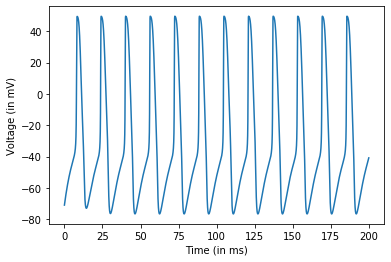

In [7]:
plt.plot(t,state.T[0,:])

plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")

plt.show()

#### Simulating Multiple Independent HH Neurons at the Same Time

Here we illustrate some simple steps that can be used to simulate populations of neurons efficiently. Key to setting up the equations is to order it in a manner that utilizes TensorFlow's algorithms that distribute vector, matrix and tensor computations over multiple cores. Consider a system of 20 independent HH neurons with different input currents that characterise the firing rates.  

##### Methods of Parallelization
TensorFlow has built-in functions that speed up Tensor computations using available multi-cores, and GPU/TPU setups. There are two major parts of the code where such a speed-up can be effected

1. **RK4 iterations** Our implementation of the integrator utilizes Tensors as inputs. 
2. **Functional Evaluations:** The form of the equations that describe the neuronal dynamics,  are common across neurons. Only the parameters for differ across neurons. This can be used to `vectorize' the equations.

Say $\vec{X}=[V,m,n,h]$ is the state vector of a single neuron and its dynamics are defined using parameters $C_m,g_K,...E_L$ equations of the form: 

\begin{eqnarray}\frac{d\vec{X}}{dt} = [f_1(\vec{X},C_m,g_K,...E_L),f_2(\vec{X},C_m,g_K,...E_L)...f_m(\vec{X},C_m,g_K,...E_L)]\end{eqnarray}

We can convert these equations to a form in which all evaluations are done as vector calculations and NOT scalar calculations. Despite the parameters being different, the functional forms of the equations are similar for the same state variable of different neurons. Thus, the trick is to reorganize $\mathbf{X}$ as $\mathbf{X'}=[(V_1,V_2,...V_n),(m_1,m_2,...m_n),(h_1,h_2,...h_n),(n_1,n_2,...n_n)]=[\vec{V},\vec{m},\vec{h},\vec{n}]$. And the parameters as $[\vec{C_m},\vec{g_K}] = [C_{m_{1}}\dots C_{m_{n}},g_{K_{1}}\dots g_{K_{n}}]$ and so on.

The advantage of this re-ordering is that the differential equation of the form,
\begin{eqnarray}\frac{dV_i}{dt}=f(V_i,m_i,h_i,n_i,C_{m_i},g_{K_i}...)\end{eqnarray}

is now easily parallelizable using a vector computation of the form, 

\begin{eqnarray}\frac{d\vec{V}}{dt}=f(\vec{V},\vec{m},\vec{h},\vec{n},\vec{C_m},\vec{g_K}...)\end{eqnarray}

The equations can now be written in the form,
\begin{eqnarray}\frac{d\mathbf{X'}}{dt}= \Big[\frac{d\vec{V}}{dt},\frac{d\vec{m}}{dt},\frac{d\vec{h}}{dt},\frac{d\vec{n}}{dt}\Big]\end{eqnarray}

In [8]:
n_n = 20 # number of simultaneous neurons to simulate

# parameters will now become n_n-vectors

C_m = [1.0]*n_n
g_K = [10.0]*n_n
E_K = [-95.0]*n_n

g_Na = [100]*n_n
E_Na = [50]*n_n 

g_L = [0.15]*n_n
E_L = [-55.0]*n_n


def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

def dXdt(X, t):
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:]       # Last n_n values are Potassium Gating Variables
    
    dVdt = (np.linspace(0,10,n_n) - I_Na(V, m, h) - I_K(V, n) -I_L(V)) / C_m 
    # Input current is linearly varied between 0 and 10
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0)
    return out


y0 = tf.constant([-71]*n_n+[0,0,0]*n_n, dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,200,epsilon)

state = odeint(dXdt,y0,t)

with tf.Session() as sess:
    state = sess.run(state)

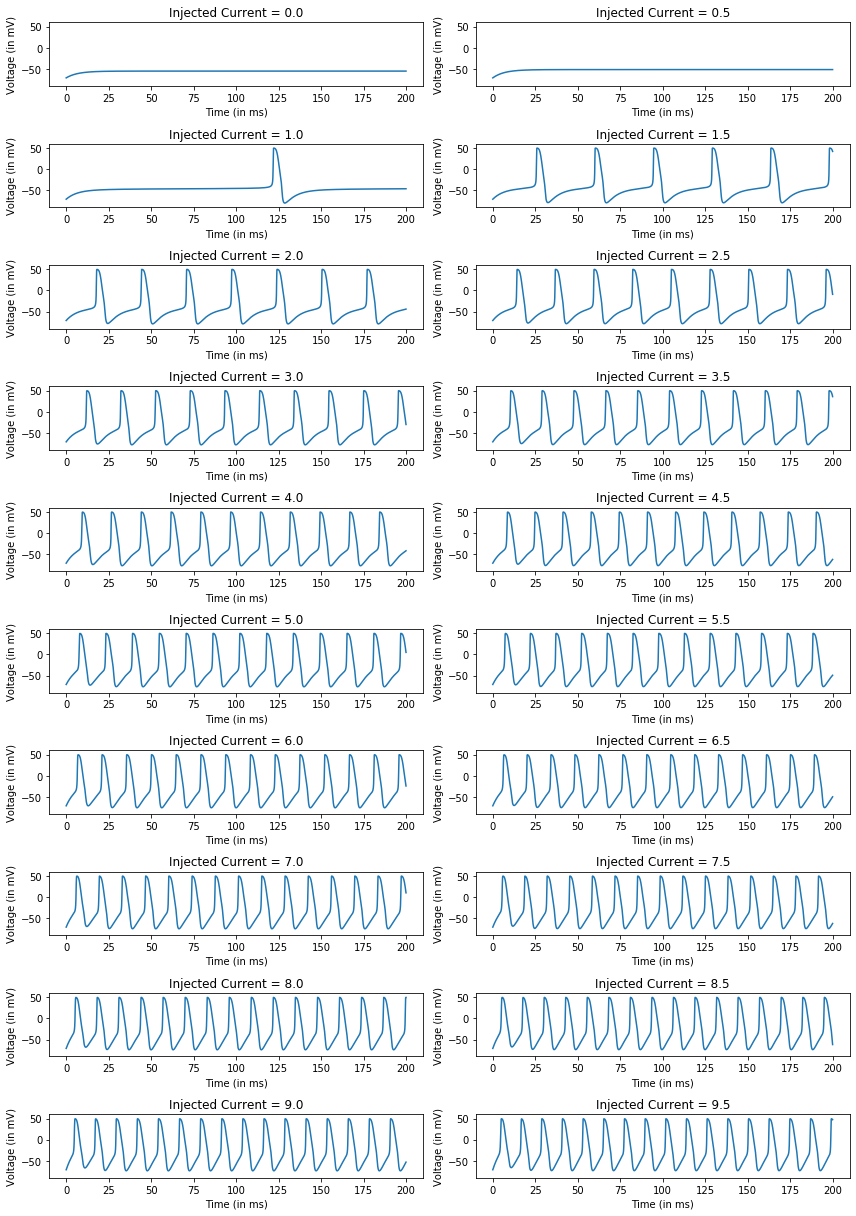

In [9]:
plt.figure(figsize=(12,17))
for i in range(20):
    plt.subplot(10,2,i+1)
    plt.plot(t,state[:,i])
    plt.title("Injected Current = {:0.1f}".format(i/2))
    plt.ylim([-90,60])
    plt.xlabel("Time (in ms)")
    plt.ylabel("Voltage (in mV)")

plt.tight_layout()
plt.show()

#### Quantifying the Firing Rates against Input Current

The firing frequency as a function of the input is shown in the figure below. The code to generate the firing rate is below.

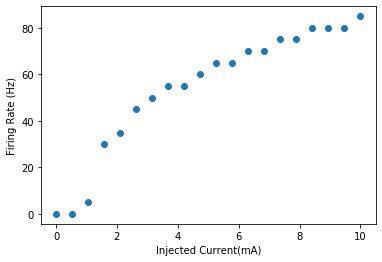

In [10]:
plt.plot(np.linspace(0,10,20),np.bitwise_and(state[:-1,:20]<0,state[1:,:20]>0).sum(axis=0)/0.2,"o")
plt.xlabel("Injected Current(mA)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

# References

(<a id="cit-Dayan2005" href="#call-Dayan2005">Dayan and Abbott, 2005</a>) Peter Dayan and Larry F. Abbott, ``Theoretical Neuroscience - Computational and Mathematical Modeling of Neural Systems``,  2005.

(<a id="cit-Johnston1995" href="#call-Johnston1995">Johnston and Wu, 1995</a>) D. Johnston and S. M.S. Wu, ``Foundations of cellular neurophysiology``,  1995.

(<a id="cit-Huxley1952" href="#call-Huxley1952">Huxley and Hodgkin, 1952</a>) Huxley A. L. and Hodgkin A. F., ``Quantitative description of nerve current``, Journal of Physiology, vol. , number , pp. ,  1952.

(<a id="cit-gerstnerMOOC" href="#call-gerstnerMOOC">MOOC</a>) , ``Neuronal dynamics``,  .  [online](https://www.edx.org/course/neuronal-dynamics)

(<a id="cit-compneuroMOOC" href="#call-compneuroMOOC">MOOC</a>) , ``Computational Neuroscience``,  .  [online](https://www.coursera.org/learn/computational-neuroscience)

(<a id="cit-Gerstner2014" href="#call-Gerstner2014">Gerstner, Kistler <em>et al.</em>, 2014</a>) Wulfram Gerstner, Werner M. Kistler, Richard Naud <em>et al.</em>, ``Neuronal dynamics: From single neurons to networks and models of cognition``,  2014.

